In [1]:
!pip install segmentation_models
!yes | pip install tensorflow==2.8
!yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 537.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.5/497.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.4
    Uninstalling tensorflow-2.6.4:

In [2]:
import os
!cp -r /kaggle/input/electron-microscopy-particle-segmentation /kaggle/working
os.chdir('/kaggle/working/electron-microscopy-particle-segmentation')

# Split train validation test

In [3]:
import numpy as np
import random

In [4]:
train_images_dir = 'images'
train_maps_dir = 'segmaps'

In [5]:
train_images = np.array(os.listdir(train_images_dir), dtype = object)
train_maps = np.array(os.listdir(train_maps_dir), dtype = object)

print(f"There are {len(train_images)} of images")
print(f"There are {len(train_maps)} of masks")

There are 465 of images
There are 465 of masks


In [6]:
!mkdir val_images
!mkdir val_segmaps

!mkdir test_images
!mkdir test_segmaps

In [7]:
val_images_dir = 'val_images'
val_maps_dir = 'val_segmaps'

test_images_dir = 'test_images'
test_maps_dir = 'test_segmaps'

In [8]:
data_len = 465
def update_train():
    global train_images, train_maps
    train_images = np.array(os.listdir(train_images_dir), dtype = object)
    train_maps = np.array(os.listdir(train_maps_dir), dtype = object)

def split_data(split_img_dir, split_map_dir, percentage = 0.2):
    n = int(data_len * percentage)
    ids = np.random.choice(train_images, n, replace = False)
    for sample in ids:
        img_fp = os.path.join(train_images_dir, sample)
        map_fp = os.path.join(train_maps_dir, sample)
        os.system(f"mv {img_fp} {split_img_dir}")
        os.system(f"mv {map_fp} {split_map_dir}")

    #update training images list
    update_train()

In [9]:
split_data(val_images_dir, val_maps_dir, 0.1)
split_data(test_images_dir,test_maps_dir, 0.2)

In [10]:
images = np.array(os.listdir(train_images_dir), dtype = object)
maps = np.array(os.listdir(train_maps_dir), dtype = object)

print(f"There are {len(images)} of train images")
print(f"There are {len(maps)} of train masks")

There are 326 of train images
There are 326 of train masks


In [11]:
val_images = np.array(os.listdir(val_images_dir), dtype = object)
val_maps = np.array(os.listdir(val_maps_dir), dtype = object)

print(f"There are {len(val_images)} of val images")
print(f"There are {len(val_maps)} of val masks")

There are 46 of val images
There are 46 of val masks


In [12]:
test_images = np.array(os.listdir(test_images_dir), dtype = object)
test_maps = np.array(os.listdir(test_maps_dir), dtype = object)

print(f"There are {len(test_images)} of test images")
print(f"There are {len(test_maps)} of test masks")

There are 93 of test images
There are 93 of test masks


# Data Loader

In [13]:
import cv2
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

In [14]:
class Dataset:
    def __init__(self, 
               images_dir,
               maps_dir,
               augmentation = None,
               preprocessing = None):
    
        self.img_ids = os.listdir(images_dir)

        self.img_fps = [os.path.join(images_dir, id ) for id in self.img_ids]
        self.map_fps = [os.path.join(maps_dir, id ) for id in self.img_ids]

        self.maps_dir = maps_dir
        self.augmentation = augmentation
        self.preprocessing = preprocessing


    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.img_fps[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512,512))

        map = Image.open(os.path.join(self.map_fps[idx]))
        map = np.array(map).astype('uint8')
        map[map > 0] = 1
        map = cv2.resize(map, (512,512))
        map = np.expand_dims(map, axis = -1)


        if self.augmentation:
            aug_sample = self.augmentation(image = image, mask = map)
            image, map = aug_sample['image'], aug_sample['mask']

        if self.preprocessing:
            processed_sample = self.preprocessing(image = image, mask = map)
            image, map = processed_sample['image'], processed_sample['mask']

        return image, map.astype(np.float32)

    def __len__(self):
        return len(self.img_ids)

In [15]:
class DataLoader(Sequence):
    def __init__(self, dataset, batch_size = 1, shuffle = False):
        self.indices = np.arange(len(dataset))
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size

        data = []
        for idx in range(start, stop):
            data.append(self.dataset[idx])

        batch = [np.stack(samples, axis = 0) for samples in zip(*data)]

        return batch

    def __len__(self):
        return len(self.indices) // self.batch_size
  
    def on_epoch_end(self):
        if self.shuffle:
            self.indices = np.random.permutation(self.indices)

## Augmentation

In [16]:
def get_augmentation():
    transforms = [
          A.HorizontalFlip(p=0.5),
          A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.8),
          A.RandomBrightnessContrast(contrast_limit=0.3, brightness_limit=0.3, p=0.2),
          A.OneOf([
                A.ImageCompression(p=0.8),
                A.RandomGamma(p=0.8),
                A.Blur(p=0.8),
            ], p=1.0),
          A.OneOf([
                A.ImageCompression(p=0.8),
                A.RandomGamma(p=0.8),
                A.Blur(p=0.8),
            ], p=1.0),
          A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_CONSTANT),
      ]

    return A.Compose(transforms)

def get_preprocessing(preprocessing_fn):
    _transform = [
            A.Lambda(image=preprocessing_fn),
        ]
    return A.Compose(_transform)

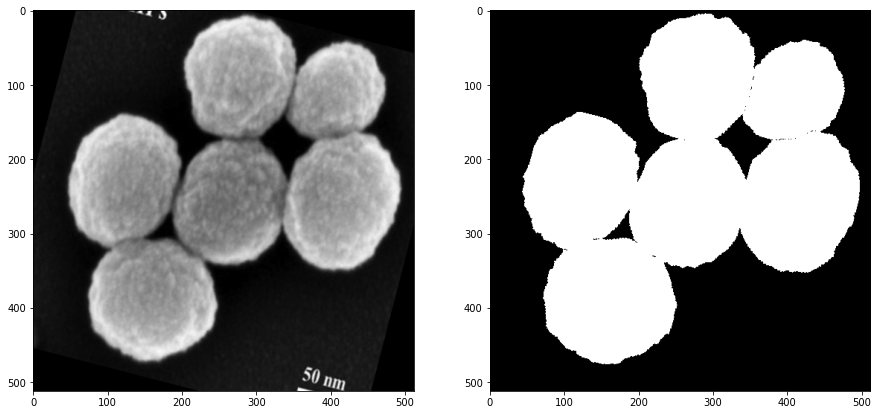

In [17]:
dataset = Dataset(train_images_dir, train_maps_dir, augmentation = get_augmentation())

sample_img, sample_map = dataset[2]

fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].imshow(sample_img)
ax[1].imshow(np.squeeze(sample_map), cmap = 'gray')

# Model Training

In [18]:
import segmentation_models as sm
import tensorflow as tf

Segmentation Models: using `keras` framework.


In [19]:
sm.set_framework('tf.keras')

In [20]:
BACKBONE = 'efficientnetb3'
ACTIVATION = 'sigmoid'
BATCH_SIZE = 8
NUM_CLASSES = 1
LR = 1e-4
EPOCHS = 50


preprocess_input = sm.get_preprocessing(BACKBONE)

In [21]:
model = sm.Unet(BACKBONE, classes=NUM_CLASSES, activation=ACTIVATION)

44122112/44107200 [==============================] - 11s 0us/step


In [22]:
optim = tf.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

In [23]:
# Dataset for train images
train_dataset = Dataset(
    train_images_dir, 
    train_maps_dir, 
    augmentation=get_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    val_images_dir, 
    val_maps_dir,
    augmentation=get_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, NUM_CLASSES)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau()
]

In [24]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50


2022-08-15 16:51:04.057795: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-08-15 16:51:21.823277: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-08-15 16:51:22.347256: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-08-15 16:51:22.820880: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 1/40 [..............................] - ETA: 14:56 - loss: 1.0437 - iou_score: 0.2053 - f1-score: 0.3406

2022-08-15 16:51:27.584644: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


 5/40 [==>...........................] - ETA: 23s - loss: 0.9125 - iou_score: 0.2737 - f1-score: 0.4265

2022-08-15 16:51:30.233378: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


40/40 [==============================] - 55s 829ms/step - loss: 0.7337 - iou_score: 0.3680 - f1-score: 0.5261 - val_loss: 0.5823 - val_iou_score: 0.5700 - val_f1-score: 0.6899 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - 30s 756ms/step - loss: 0.4946 - iou_score: 0.6710 - f1-score: 0.7964 - val_loss: 0.4983 - val_iou_score: 0.6936 - val_f1-score: 0.7900 - lr: 1.0000e-04
Epoch 3/50
40/40 [==============================] - 30s 756ms/step - loss: 0.3943 - iou_score: 0.7856 - f1-score: 0.8760 - val_loss: 0.4281 - val_iou_score: 0.7662 - val_f1-score: 0.8482 - lr: 1.0000e-04
Epoch 4/50
40/40 [==============================] - 30s 746ms/step - loss: 0.3236 - iou_score: 0.8443 - f1-score: 0.9134 - val_loss: 0.3750 - val_iou_score: 0.8297 - val_f1-score: 0.8920 - lr: 1.0000e-04
Epoch 5/50
40/40 [==============================] - 30s 755ms/step - loss: 0.2790 - iou_score: 0.8674 - f1-score: 0.9276 - val_loss: 0.3409 - val_iou_score: 0.8605 - val_f1-score: 0.9080 - lr: 1.

# Model Evaluation

In [25]:
test_dataset = Dataset(
    test_images_dir, 
    test_maps_dir,  
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [26]:
model.load_weights('best_model.h5') 

In [27]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.11298
mean iou_score: 0.90616
mean f1-score: 0.94653


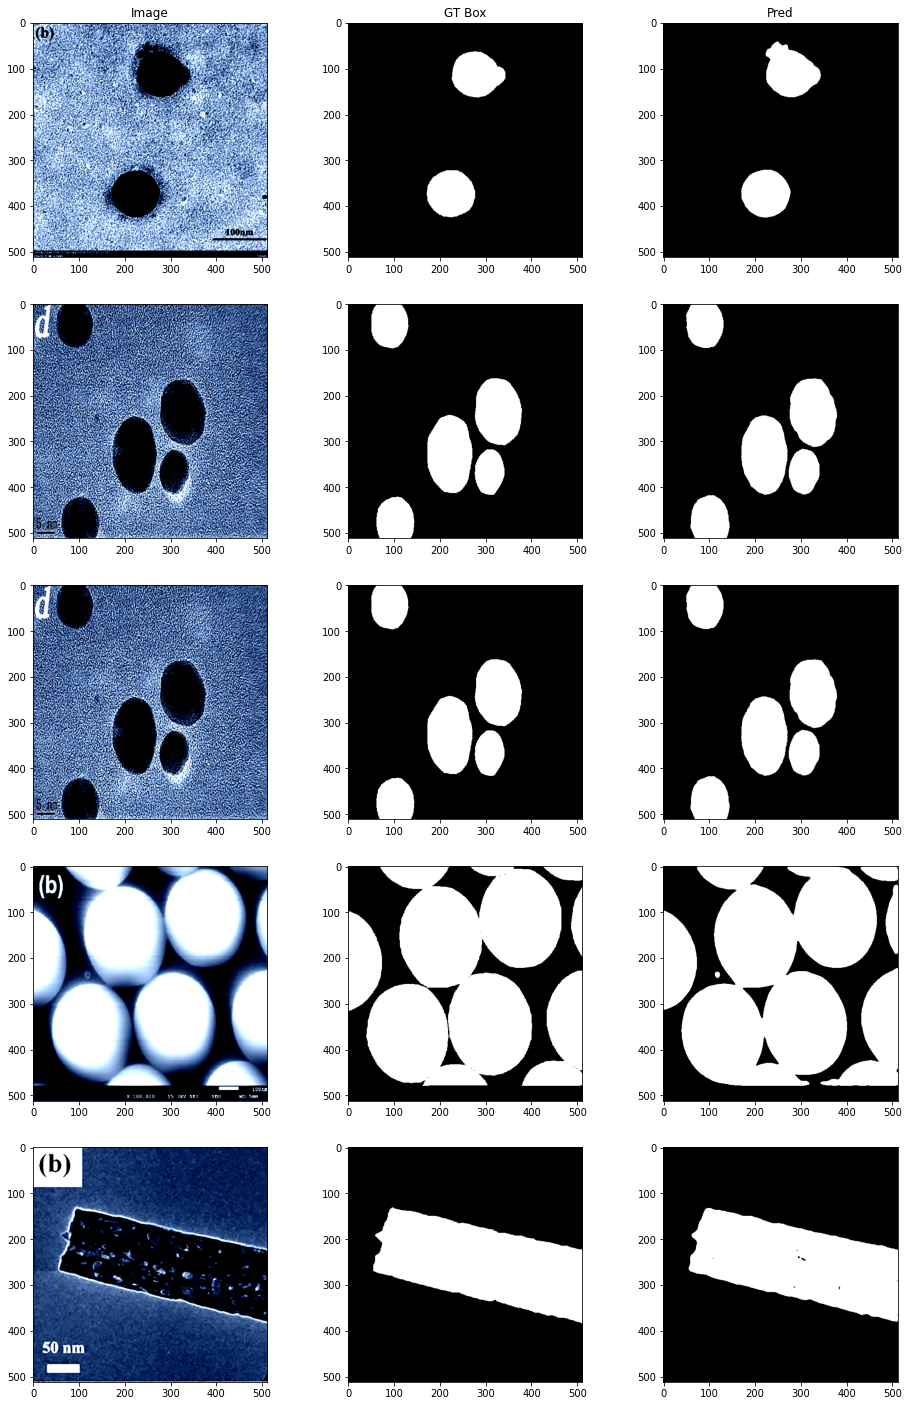

In [28]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

fig, axes = plt.subplots(n, 3, figsize = (16,25))

cols = ['Image', "GT Box", "Pred"]
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

axes = axes.ravel()
for i,id in enumerate(ids):
  image, gt_mask = test_dataset[id]
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()

  for j, im in enumerate([image, gt_mask, pr_mask]):
     axes[i*3+j].imshow(np.squeeze(im), cmap = 'gray')